# 10/31 Redoing (again) current restructure_data_compute_transports
## generalize transects 

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [21]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
# dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [22]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [23]:
ds = mps.add_grid_info_coords(mesh,dss)

In [24]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [25]:
# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

Opening LS_test_transect_from_mask.nc file as mask


# crate mask from geojson

In [33]:
# mask_edges, mask_vertices, mask = open_from_mask(ds)

Creating .nc file
Using EOSNAP.geojson to create .nc file
EOSNAP.nc created and opened as masks


In [38]:
mask_path = './'
mask_filename = 'EOSNAP'
maks_edges, mask_vertices, mask = mps.open_from_mask(ds, mask_path, mask_filename)

Opening EOSNAP.nc file as mask


# Create mask from transect

In [27]:
# path = './'
# filename = 'SO_region_test1'
# geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
# tags = "Southern_Ocean"
# author = "Kaila Uyeda"

# lats = np.array([-75,-50,-50,-75])
# lons = np.array([250, 250, 350, 350])
# alg_edges, alg_vertices, mask = mps.open_transect_from_alg(ds,lats,lons,path,filename,geojson_file_name,tags,author)

In [28]:
# # plot this masked region
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# # LS the target start and end points when creating the algorithm
# ax.plot(lons, lats, color='blue',label='1. target_start and end')

# # plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
# # we don't need to worry about the mps.find_and_sort_transect_edges_and_vertices function because 
# # the cell centers will always be inside the mask
# # create cellmasks (which cells centers are included in the masked region)

# cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
# c = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.5,
#                   antialiaseds=False, label = '2. Cell Centers')

# fig.colorbar(c, extend='both')

# # LS (lats and lons of vertices from transect)
# # ax.scatter(test_verts_lons + 360,test_verts_lats, s=60,marker='^',color='orange',label='3. test_verts')


# # plot using vertex lats and lons (removed vertices on cells not in the mask)
# vertex_lons = ds.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
# vertex_lats = ds.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# # plot the vertices after removing where there are duplicates. 
# # the colorbar shows the index of the lons and lats for each vertex 
# # (since it is a gradient --> the vertex lats and lons are in order)
# ax.scatter(vertex_lons,vertex_lats,c=np.arange(0,len(vertex_lons)),label='3. alg_verts')

# ax.set_ylim(-80,-40)
# ax.set_xlim(240,360)

# ax.set_title('Vertex locations determined by each step in creating transects from algorithm')
# ax.legend()

# #fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

# calculate transports in density space using functions s.t. we only need to specify lats, lons, file attributes, and target remap coords

In [29]:
path = './'
filename = 'SO_region_test1'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

lats = np.array([-75,-50,-50,-75])
lons = np.array([250, 250, 350, 350])
# alg_edges, alg_vertices, mask = mps.open_transect_from_alg(ds,lats,lons,path,filename,geojson_file_name,tags,author)


# method = 'alg' # 'mask'

# # the only option is alg rn 

# if method == 'alg':
#     edges, vertices = alg_edges, alg_vertices
#     mask = mask

target_coords = np.linspace(1022,1029,100)
# dss_transect_edges_vIM, transport_transformed_cons = mps.transport_in_density_space_from_ds(ds,edges, mask, target_coords)

edges, vertices, mask, dss_transect_edges_vIM, transport_transformed_cons = mps.transports_in_density_space_all_functions(ds,lats,lons,path,filename,geojson_file_name,tags,author, target_coords)
    

SO_region_test1_transect_from_alg.geojson exists!
Opening SO_region_test1_transect_from_alg.nc as dsMasks


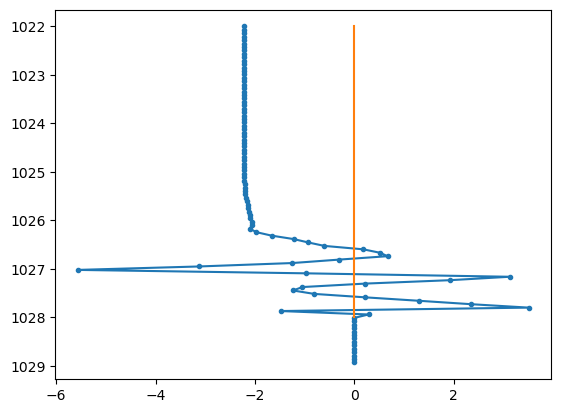

In [30]:
total_transport_Edge = transport_transformed_cons.sum('nEdges').mean(dim=['xtime_startMonthly','TWO'])
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_coords[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))